In [1]:
from libraries import *
from parameters import *
from numpy import asarray
from numpy import savetxt
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
import ot
import umap
%matplotlib inline

In [2]:
os.getcwd()
os.chdir(projectDir)

In [3]:
%load_ext rpy2.ipython

In [86]:
def ot_distance(exp1, exp2, N=None):
    if N is not None:
        s1 = np.random.choice(exp1.shape[0], N, replace=False)  
        exp1 = exp1[s1,:]
        s2 = np.random.choice(exp2.shape[0], N, replace=False)
        exp2 = exp2[s2,:]
    M = ot.dist(exp1, exp2)
    #M /= M.max()
    
    a = np.ones(len(exp1)) / len(exp1)
    b = np.ones(len(exp2)) / len(exp2)
    
    # ot_distance = ot.emd(a, b, M)
    # return np.sum(ot_distance*M)
    return ot.emd2(a, b, M)

In [87]:
adata = sc.read('outputs/anndata/adata-hash-features_SingleKO_ForSCVI_09072021.h5ad')

zs = ["K_0", "K_1","K_2", "K_3", "K_4", "K_5", "K_CONTROL"]
#mpl.rcParams["axes.prop_cycle"]

In [88]:
adata.obs["subCellType"] = "DC2"
adata.obs.loc[adata.obs.leiden.isin(['3']), "subCellType"] = "MacDC"
adata.obs.loc[adata.obs.leiden.isin(['8']), "subCellType"] = "DC1"
adata.obs.loc[adata.obs.leiden.isin(['5']), "subCellType"] = "MReg"
adata.obs.loc[adata.obs.leiden.isin(['9']), "subCellType"] = "Neut"
adata.obs.loc[adata.obs.leiden.isin(['6', '4', '7']), "subCellType"] = "Other"

In [89]:
dcGenes = pd.read_csv('./PositiveControls/DC_cellstate_genes.csv')

dc1Genes = dcGenes["DC1 genes"].unique()
dc2Genes = dcGenes["DC2 genes"].unique()
mregGenes = dcGenes["mregDC genes"].unique()

macGenes = dcGenes["Macrophage genes"].unique()
sc.tl.score_genes(adata=adata, gene_list=macGenes, score_name="Mac")


allDCgenes = np.concatenate((dc1Genes, dc2Genes, mregGenes))
sc.tl.score_genes(adata=adata, gene_list=allDCgenes, score_name="DCSig")

adata.obs["DCSig_zscore"] = scipy.stats.zscore(adata.obs["DCSig"])
adata.obs["Mac_zscore"] = scipy.stats.zscore(adata.obs["Mac"])

adata.obs["MACoverDC"] = adata.obs["Mac_zscore"] - adata.obs["DCSig_zscore"]

computing score 'Mac'


/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'Mac', score of gene set (adata.obs).
    1087 total control genes are used. (0:00:03)
computing score 'DCSig'


/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'DCSig', score of gene set (adata.obs).
    1098 total control genes are used. (0:00:04)


In [91]:
adata = adata[adata.obs['subCellType'] == "DC2",]
#adata = adata[adata.obs.leiden == '0',]

In [92]:
adata.obs

,barcode_rank,channel,empty_drops_FDR,log10_n_genes,log10_n_umis,mt_frac,n_counts,n_genes,n_umis,neg_log10_empty_drops_FDR,...,K_5,K_CONTROL,Doubles,DoubleSameGroup,subCellType,Mac,DCSig,DCSig_zscore,Mac_zscore,MACoverDC
AAACGAAAGCAGTCTT-1-E3-1-0,6446.0,1,0.0,3.285107,3.714833,0.059391,5186.0,1656,5186.0,4.0,...,0,0,0,0,DC2,0.381396,0.134954,1.105931,0.658832,-0.447099
AAACGAATCTCAACCC-1-E3-1-0,4937.0,1,0.0,3.305996,3.756103,0.063300,5703.0,1721,5703.0,4.0,...,0,0,0,0,DC2,0.352136,0.076629,-0.635825,0.380713,1.016538
AAACGCTAGTTGTAGA-1-E3-1-0,20114.5,1,0.0,3.033021,3.399674,0.086056,2510.0,951,2510.0,4.0,...,0,1,0,0,DC2,0.352481,0.049651,-1.441460,0.383991,1.825451
AAACGCTCAAAGACGC-1-E3-1-0,5744.0,1,0.0,3.260310,3.733518,0.065386,5414.0,1567,5414.0,4.0,...,0,0,0,0,DC2,0.256307,0.029265,-2.050262,-0.530135,1.520127
AAACGCTCAGTGTACT-1-E3-1-0,10821.5,1,0.0,3.251151,3.627366,0.108019,4240.0,1518,4240.0,4.0,...,0,0,0,0,DC2,0.231609,0.048610,-1.472559,-0.764892,0.707667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACCTGATA-1-E4-24-0,10541.0,24,0.0,3.390759,3.906173,0.082165,8057.0,2023,8057.0,4.0,...,0,0,0,0,DC2,0.404473,0.134249,1.084882,0.878179,-0.206703
TTTGGTTCAGATCACT-1-E4-24-0,13428.0,24,0.0,3.380392,3.849112,0.065817,7065.0,2053,7065.0,4.0,...,0,0,0,0,DC2,0.420625,0.124963,0.807560,1.031698,0.224138
TTTGGTTGTCATCACA-1-E4-24-0,17692.0,24,0.0,3.294907,3.733839,0.050018,5418.0,1725,5418.0,4.0,...,0,0,0,0,DC2,0.293106,0.099970,0.061202,-0.180362,-0.241565
TTTGTTGAGTCATCCA-1-E4-24-0,3210.5,24,0.0,3.481443,4.091421,0.069108,12343.0,2548,12343.0,4.0,...,0,0,0,0,DC2,0.333255,0.073762,-0.721432,0.201254,0.922686


In [93]:
fBarMat_grouped = adata.obs[zs].T

In [94]:
fBarMat_groupedDeneme = fBarMat_grouped.apply(lambda x: ''.join(x.dropna().astype(str)))

In [95]:
fBarMat_groupedDeneme

AAACGAAAGCAGTCTT-1-E3-1-0     0100000
AAACGAATCTCAACCC-1-E3-1-0     0001000
AAACGCTAGTTGTAGA-1-E3-1-0     0000001
AAACGCTCAAAGACGC-1-E3-1-0     1000000
AAACGCTCAGTGTACT-1-E3-1-0     0010000
                               ...   
TTTGGTTCACCTGATA-1-E4-24-0    0010000
TTTGGTTCAGATCACT-1-E4-24-0    0001000
TTTGGTTGTCATCACA-1-E4-24-0    0001000
TTTGTTGAGTCATCCA-1-E4-24-0    1000000
TTTGTTGCAGGACATG-1-E4-24-0    1000000
Length: 87770, dtype: object

In [96]:
label_encoder = LabelEncoder()

In [97]:
fBarMat_encodedDF = pd.Series(label_encoder.fit_transform(fBarMat_groupedDeneme))
fBarMat_encodedDF.index = fBarMat_groupedDeneme.index

In [98]:
fBarMat_grouped.sum(axis=1)

K_0          16616
K_1          12529
K_2          11629
K_3          12067
K_4           3684
K_5           1415
K_CONTROL    29830
dtype: int64

In [99]:
fBarMat_encodedDF.value_counts()

0    29830
6    16616
5    12529
3    12067
4    11629
2     3684
1     1415
dtype: int64

In [100]:
adata.obs["perCat"] = fBarMat_encodedDF

/tmp/ipykernel_15722/393659493.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["perCat"] = fBarMat_encodedDF


In [101]:
fBarMat_encodedDF[fBarMat_encodedDF==6] = "K0"
fBarMat_encodedDF[fBarMat_encodedDF==5] = "K1"
fBarMat_encodedDF[fBarMat_encodedDF==4] = "K2"
fBarMat_encodedDF[fBarMat_encodedDF==3] = "K3"
fBarMat_encodedDF[fBarMat_encodedDF==2] = "K4"
fBarMat_encodedDF[fBarMat_encodedDF==1] = "K5"
fBarMat_encodedDF[fBarMat_encodedDF==0] = "CONTROL"

In [102]:
adata.obs["perCatGroups"] = fBarMat_encodedDF

In [103]:
adata.obs["perCatGroups"]

AAACGAAAGCAGTCTT-1-E3-1-0          K1
AAACGAATCTCAACCC-1-E3-1-0          K3
AAACGCTAGTTGTAGA-1-E3-1-0     CONTROL
AAACGCTCAAAGACGC-1-E3-1-0          K0
AAACGCTCAGTGTACT-1-E3-1-0          K2
                               ...   
TTTGGTTCACCTGATA-1-E4-24-0         K2
TTTGGTTCAGATCACT-1-E4-24-0         K3
TTTGGTTGTCATCACA-1-E4-24-0         K3
TTTGTTGAGTCATCCA-1-E4-24-0         K0
TTTGTTGCAGGACATG-1-E4-24-0         K0
Name: perCatGroups, Length: 87770, dtype: object

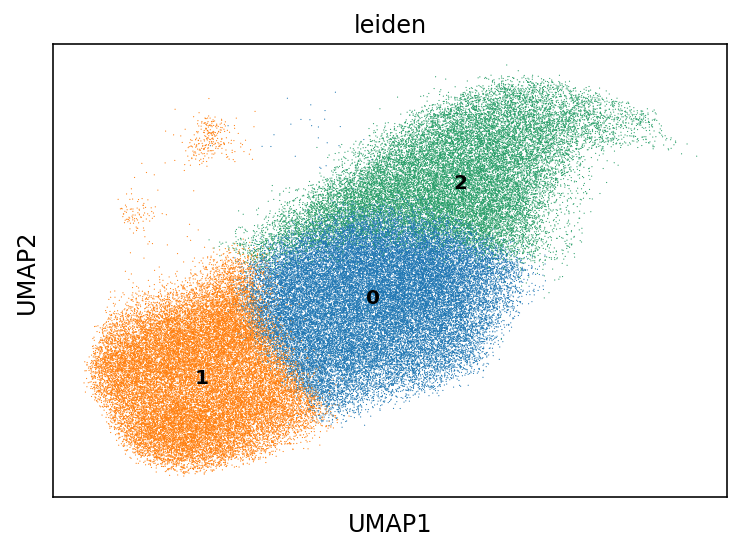

In [104]:
sc.pl.umap(adata, color='leiden', legend_loc="on data")

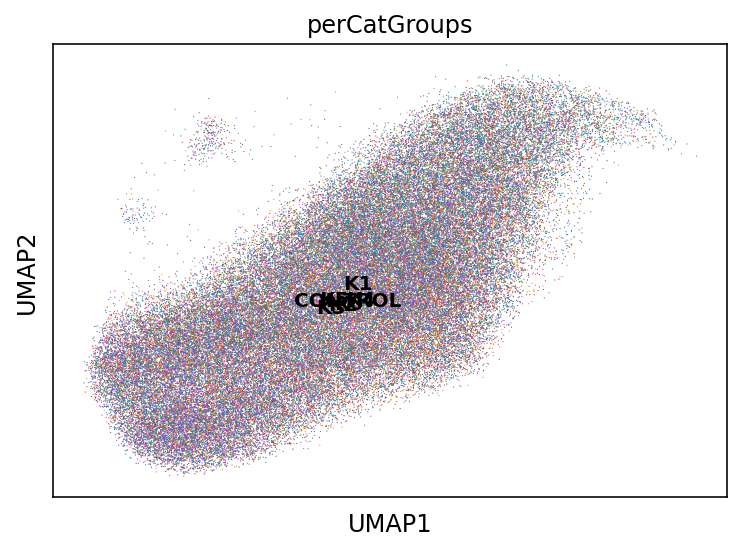

In [228]:
sc.pl.umap(adata, color='perCatGroups', legend_loc="on data")

In [285]:
#embedding = umap.UMAP(n_neighbors=18 ).fit_transform(X=pd.DataFrame(adata.X), y=np.array(adata.obs["perCat"]))

In [176]:
embedding.shape

(87770, 2)

In [306]:
#np.save("./TempPythonFiles/SupervisedEmbedding.npy", embedding)

In [ ]:
#embedding = np.load("./TempPythonFiles/SupervisedEmbedding.npy")

In [169]:
embedding.shape

(87770, 2)

/tmp/ipykernel_15722/1780097716.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(boundaries=np.arange(8)-0.5)


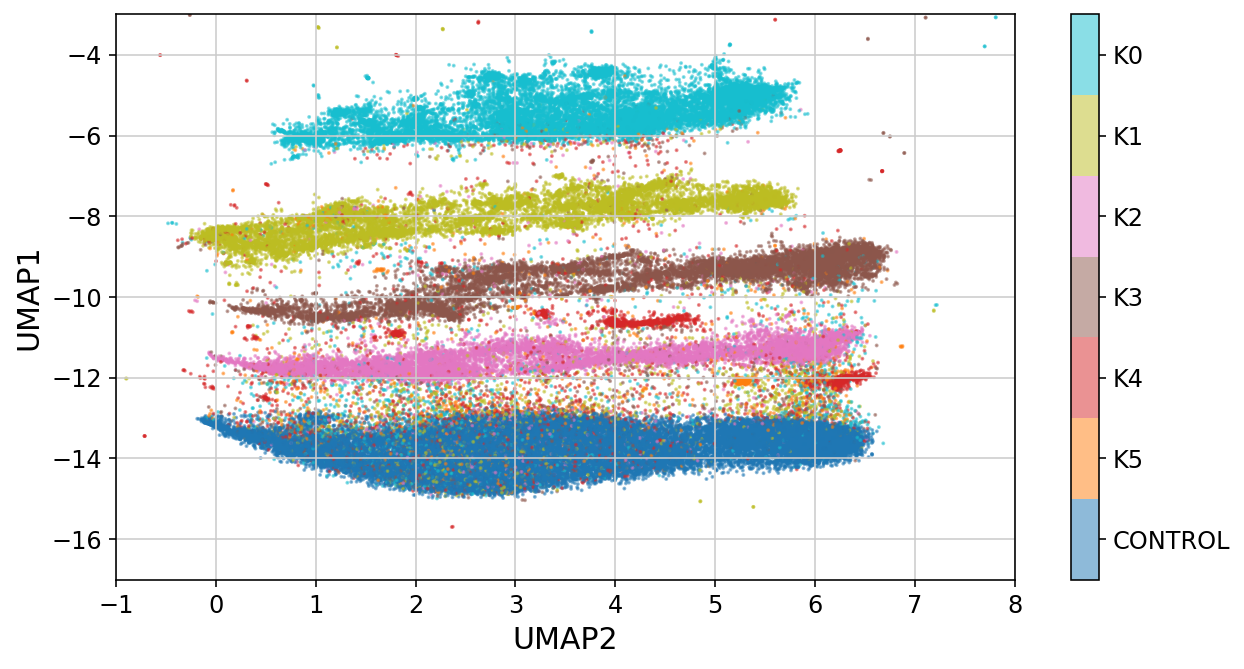

In [305]:
classes = ["CONTROL","K5","K4","K3", "K2","K1", "K0"]
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(*embedding.T, s=0.9, c=adata.obs["perCat"], cmap='tab10', alpha=0.5)
plt.ylim(-17, -3)
plt.xlim(-1, 8)
#plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(8)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.ylabel('UMAP1', fontsize = 15) # x-axis label with fontsize 15
plt.xlabel('UMAP2', fontsize = 15) # y-axis label with fontsize 15

plt.savefig('Figure_3C.pdf')  

In [300]:
max(adata.obs["MACoverDC"])

3.279620152316773

In [301]:
min(adata.obs["MACoverDC"])

-5.408984146215863

In [302]:
np.arange(-6,4)

array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3])

/tmp/ipykernel_15722/3183433588.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(boundaries=np.arange(-6,4))


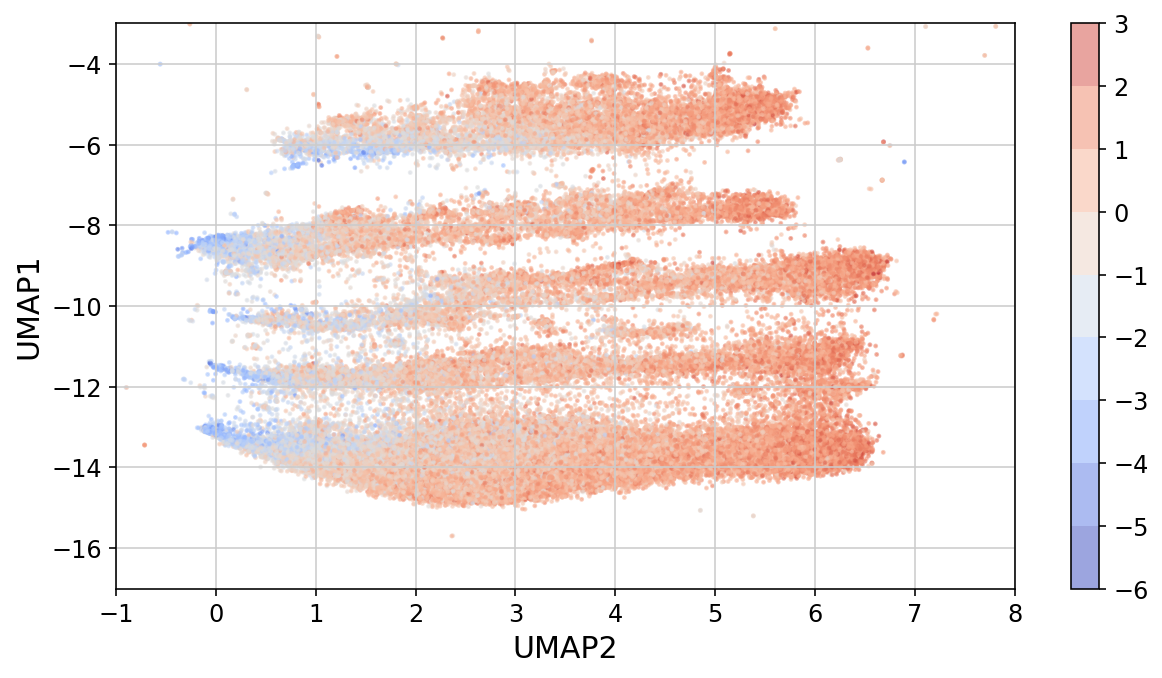

In [304]:
fig, ax = plt.subplots(1, figsize=(10, 5))
plt.scatter(*embedding.T, s=2, c=adata.obs["MACoverDC"], cmap='coolwarm',alpha=0.5)
plt.ylim(-17, -3)
plt.xlim(-1, 8)
#plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(-6,4))
cbar.set_ticks(np.arange(-6,4))
plt.ylabel('UMAP1', fontsize = 15) # x-axis label with fontsize 15
plt.xlabel('UMAP2', fontsize = 15) # y-axis label with fontsize 15

plt.savefig('Figure_3C_supplement.pdf') 

In [148]:
inDat = adata.X.copy()

In [149]:
inDat

array([[-0.6237246 , -0.6930194 ,  0.5183212 , ...,  1.9602153 ,
         0.29733798,  0.923197  ],
       [-0.6237246 , -0.6930194 , -1.0737704 , ..., -0.763166  ,
        -0.03872837, -0.6023048 ],
       [-0.6237246 , -0.6930194 ,  1.9815084 , ..., -0.763166  ,
         0.16917124, -3.2758043 ],
       ...,
       [-0.6237246 , -0.6930194 ,  0.47637606, ..., -0.763166  ,
        -0.23513708,  0.5173905 ],
       [-0.6237246 ,  0.8894596 , -0.4618995 , ..., -0.1885937 ,
        -0.25461894,  0.2765866 ],
       [ 2.076361  , -0.6930194 , -1.0737704 , ..., -0.763166  ,
         0.42477238,  0.7100031 ]], dtype=float32)

In [160]:
real_dist_mat = pd.DataFrame(np.zeros((7, 7))) 
real_dist_mat.index= ['CONTROL', 'K0','K1', 'K2', 'K3', 'K4', 'K5']
real_dist_mat.columns= ['CONTROL', 'K0', 'K1', 'K2', 'K3', 'K4', 'K5']


In [184]:
indNames= ['CONTROL', 'K0', 'K1', 'K2', 'K3', 'K4', 'K5']

for i in range(7):
    for j in range(i, 7):
        x = inDat[adata.obs["perCatGroups"] == indNames[i],] 
        y = inDat[adata.obs["perCatGroups"] == indNames[j],] 

        otDists =  pd.DataFrame(np.zeros((100)))

        for z in range(100):
            otDists.loc[z] = ot_distance(x, y, N=300)

        real_dist_mat.loc[indNames[i],indNames[j]] = np.round(np.float(otDists.mean(axis=0)), -1)


/tmp/ipykernel_15722/2509903899.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  real_dist_mat.loc[indNames[i],indNames[j]] = np.round(np.float(otDists.mean(axis=0)), -1)


In [162]:
otDists

,0
0,1459.567899
1,1524.688860
2,1380.921528
3,1417.870378
4,1502.417249
...,...
95,1435.965786
96,1425.386336
97,1542.215675
98,1433.317551


In [208]:
#np.save("./TempPythonFiles/WassersteinDistMat_AllCellsWithoutSubsampling_2.npy", real_dist_mat)

In [12]:
real_dist_mat = pd.DataFrame(np.load("./TempPythonFiles/WassersteinDistMat_AllCellsWithoutSubsampling_2.npy"))

In [13]:
real_dist_mat.columns = ["CONTROL", "K0", "K1", "K2", "K3", "K4", "K5"]
real_dist_mat.index = ["CONTROL", "K0", "K1", "K2", "K3", "K4", "K5"]

In [16]:
real_dist_mat

,CONTROL,K0,K1,K2,K3,K4,K5
CONTROL,1700.0,1750.0,1730.0,1720.0,1720.0,1770.0,1780.0
K0,0.0,1750.0,1760.0,1750.0,1750.0,1800.0,1810.0
K1,0.0,0.0,1690.0,1740.0,1740.0,1790.0,1790.0
K2,0.0,0.0,0.0,1680.0,1730.0,1780.0,1790.0
K3,0.0,0.0,0.0,0.0,1680.0,1780.0,1780.0
K4,0.0,0.0,0.0,0.0,0.0,1670.0,1840.0
K5,0.0,0.0,0.0,0.0,0.0,0.0,1440.0


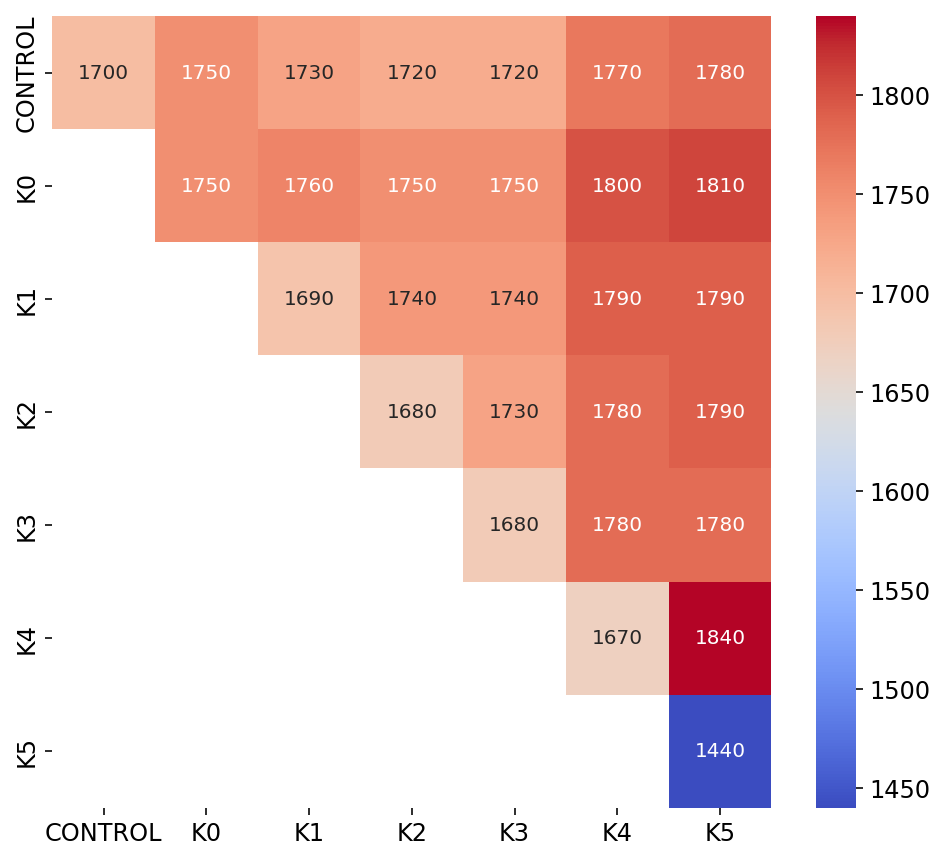

In [15]:
plt.figure(figsize = (8,7))

mask = np.zeros_like(real_dist_mat)
mask[np.tril_indices_from(mask, k=-1)] = True
#sns.heatmap(corr, mask=mask, vmax=.3, square=True)

#ax = sns.heatmap(real_dist_mat, annot=True, mask=mask, vmin=6, vmax=9.5)
ax = sns.heatmap(real_dist_mat, annot=True, mask=mask, cmap="coolwarm", fmt='.0f')
#plt.ylabel('Real values', fontsize = 15) # x-axis label with fontsize 15
#plt.xlabel('Real values', fontsize = 15) # y-axis label with fontsize 15

#plt.show()

plt.savefig('Figure_3D.pdf')  